In [1]:
from google.colab import files


import numpy as np
import pandas as pd
import datetime
from sklearn import linear_model
from sklearn.metrics import *

# creating custom tranformer to prepare dataset

import sklearn
import seaborn as sns
import itertools

from matplotlib import pyplot as plt
from sklearn import preprocessing

In [2]:
#!pip install scikit-learn==0.24.0

In [3]:
def wmape(y_true, y_pred):
  errors = y_true - y_pred
  wmape_val = 100*np.round(np.sum(abs(errors))/np.sum(y_true),6)
  return (wmape_val, errors)

##Functions and classes

In [4]:
def extend_to_right_boundary(df, max_time):
  df_tmp = df.reset_index(level = 0, drop = True).sort_index(ascending=True)
  min_left = min(df.index)[1]
  extended_time = pd.date_range(start = min_left, end = max_time, freq ='W-Mon')
  df_tmp = df_tmp.reindex(extended_time, fill_value = 0.0)
  df_tmp.index.name = "DateTime"
  #print((df.index.get_level_values(level = 0).unique(), extended_time))

  # this does not work
  # weekly_sales.loc[[3129],:].reindex(index = multiindex.at[3129], level = "DateTime", fill_value = 0.0)

  return df_tmp

In [5]:
def prepare_sales_data(sales_df, categories_df, traffic_df, extend_to_common_horizon = False, extend_only_to_max_date = False, shift_list = [None]):
  sales_df_copy = sales_df.copy()
  sales_df_copy['DateTime'] = sales_df_copy['week_starting_date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
  weekly_sales = sales_df_copy.groupby(["product_id", "DateTime"], as_index=True).agg({'sales':'sum'}) # czy to jest potrzebne?

  if extend_to_common_horizon:
    if extend_only_to_max_date:
      max_time_value = max(weekly_sales.index.get_level_values(level = 1))
      expanded_full = weekly_sales.groupby(level=0).apply(lambda x: extend_to_right_boundary(x, max_time_value))
    else:
      t1 = weekly_sales.index.get_level_values(level = 0).unique()
      t2 = weekly_sales.index.get_level_values(level = 1).unique()
      new_index = list(itertools.product(t1, t2))
      expanded_full = weekly_sales.reindex(pd.MultiIndex.from_tuples(new_index, names=['product_id', 'DateTime']), fill_value=0)
  else:
    expanded_full = weekly_sales.groupby(level=0).apply(lambda x: x.reset_index(level=0, drop=True).asfreq("W-Mon", fill_value = 0.0))
    #expanded_full = weekly_sales.groupby(level=0).apply(lambda x: x.reset_index(level=0, drop=True).asfreq("W-Mon").fillna(0))
  
  

  full_sales_dataset = expanded_full\
  .merge(categories_df, left_index=True, right_index = True,  how = 'left')\
  .merge(traffic_df, left_index = True,  right_index = True, how = 'left')

  full_sales_dataset["Date"] = full_sales_dataset.index.get_level_values(level = 1)
  
  # adding columns based on start time
  full_sales_dataset['Week_numb'] = full_sales_dataset['Date'].apply(lambda x: int(x.strftime("%V")))
  full_sales_dataset['YW'] = full_sales_dataset['Date'].apply(lambda x: int(x.strftime("%Y%V")))
  full_sales_dataset['Month'] = full_sales_dataset['Date'].apply(lambda x: int(x.month))

  if shift_list[0] is not None:
    for i in shift_list:
      # do this but within groups, otherwise there is a bug
      full_sales_dataset[[f"sales_lag_{i}W", f"traffic_lag_{i}W"]] = full_sales_dataset.groupby(level = 0)[['sales', 'traffic']].shift(i, fill_value = 0.0)

  #full_sales_dataset["sales_to_traffic"] = full_sales_dataset.sales/full_sales_dataset.traffic
  
  full_sales_dataset.drop("Date", axis = 1, inplace = True)


  return full_sales_dataset


###### prediction methods

In [6]:
def NaiveForecast(ts_series, horizon, time_freq = "W-MON"):
  ts_time_index = ts_series.index
  ts_values = ts_series.values

  prediction = ts_values[-1]
  last_time_obs = ts_time_index[-1]

  #prediciton_time_vector = pd.date_range(last_time_obs, periods=3, freq=time_freq)
  horizon_for_loop = horizon + 1
  prediciton_time_vector = pd.Index([last_time_obs + pd.offsets.DateOffset(weeks=i) for i in range(1,horizon_for_loop,1)],  freq = "W-MON")

  prediction_vector = np.repeat(a = prediction, repeats = horizon)
  prediction_series = pd.Series(prediction_vector, index =prediciton_time_vector)

  return prediction_series

## Data Loading

In [7]:
# files with the same structure as the one sent
uploaded = files.upload()

Saving categories.csv to categories.csv
Saving sales.csv to sales.csv
Saving traffic.csv to traffic.csv


In [7]:
sales_data = pd.read_csv("sales.csv",   header = 0, sep = ";")
categories = pd.read_csv("categories.csv",   header = 0, sep = ";")
traffic = pd.read_csv("traffic.csv",   header = 0, sep = ";")

## Data preparation

In [8]:
traffic['DateTime'] = traffic['week_starting_date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
traffic.drop("week_starting_date", axis = 1, inplace = True)

traffic = traffic.set_index(["product_id", "DateTime"])
categories = categories.set_index(["product_id"])

In [9]:
# # extending to common time horizon min-max date across all the products
# sales_df_combined_full = prepare_sales_data(sales_data, categories, traffic, True, False)

In [10]:
# extended only to global max date horizon
# check nulls here because looks strange
sales_df_combined_right = prepare_sales_data(sales_data, categories, traffic, True, True, [1,2,3])

In [11]:
sales_df_combined_right

sales  category_id  ...  sales_lag_3W  traffic_lag_3W
product_id DateTime                        ...                              
1          2020-07-06    1.0           10  ...           0.0             0.0
           2020-07-13    0.0           10  ...           0.0             0.0
           2020-07-20    1.0           10  ...           0.0             0.0
           2020-07-27    3.0           10  ...           1.0             NaN
           2020-08-03    4.0           10  ...           0.0             NaN
...                      ...          ...  ...           ...             ...
3135       2020-11-30  102.0           43  ...          21.0           100.0
           2020-12-07   45.0           43  ...          29.0            81.0
           2020-12-14    8.0           43  ...         124.0           108.0
           2020-12-21   17.0           43  ...         102.0           142.0
           2020-12-28    7.0           43  ...          45.0            90.0

[217439 rows x 12 columns]

## First exploration

#### statistics on sales per product_id

In [ ]:
products_summary = sales_df_combined.groupby(level = 0).agg({'sales':["min", "max", "mean", "std", "count", "median"]})
products_summary.columns = ["_".join(x) for x in products_summary.columns.ravel()]
products_summary["rel_std"] = products_summary.sales_std/products_summary.sales_mean

In [ ]:
products_summary.sort_values(by = ["sales_mean"], ascending = False)

In [ ]:
products_summary.sort_values(by = ["rel_std"], ascending = False)

####overall sales

We see areas with higher peaks, especialy around November - December (Christmas shopping?) period. Looks like more products lanuched around April 2020 because before we sae peaks but not so significant.

In [ ]:
sales_df_copy = sales_data.copy()
sales_df_copy['DateTime'] = sales_df_copy['week_starting_date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
weekly_sales = sales_df_copy.groupby(["DateTime"], as_index=False).agg({'sales':'sum'})

weekly_sales.set_index(["DateTime"]).plot(figsize = (15,5), marker = 'o')

#### how many products per category

In [ ]:
sales_df_combined.reset_index()[["product_id", "category_id"]].drop_duplicates()

In [ ]:
sales_df_combined.reset_index()[["product_id", "category_id"]].drop_duplicates().groupby("category_id", as_index = False).count().plot.bar(x = "category_id", y = "product_id", figsize=(20,5))

####sales per category

peaks around November-December are also visible across most of the categoies which looks like global pattern.

In [9]:
category_aggr = sales_df_combined.reset_index().groupby(["DateTime", "category_id"], as_index=False).agg({'sales':'sum'})
pivoted = category_aggr[["category_id", "DateTime", "sales"]].pivot(index = "category_id", columns = "DateTime", values = "sales").fillna(0)

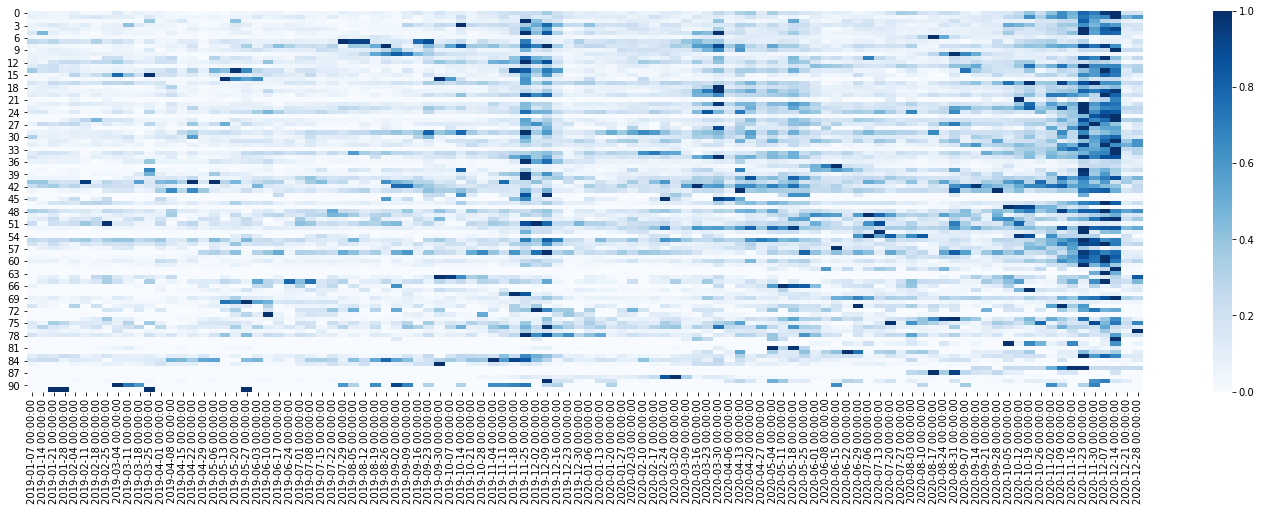

In [10]:
plt.figure(figsize = (25,7))
sns.heatmap(preprocessing.minmax_scale(pivoted.T).T,  xticklabels=pivoted.columns, cmap = 'Blues')

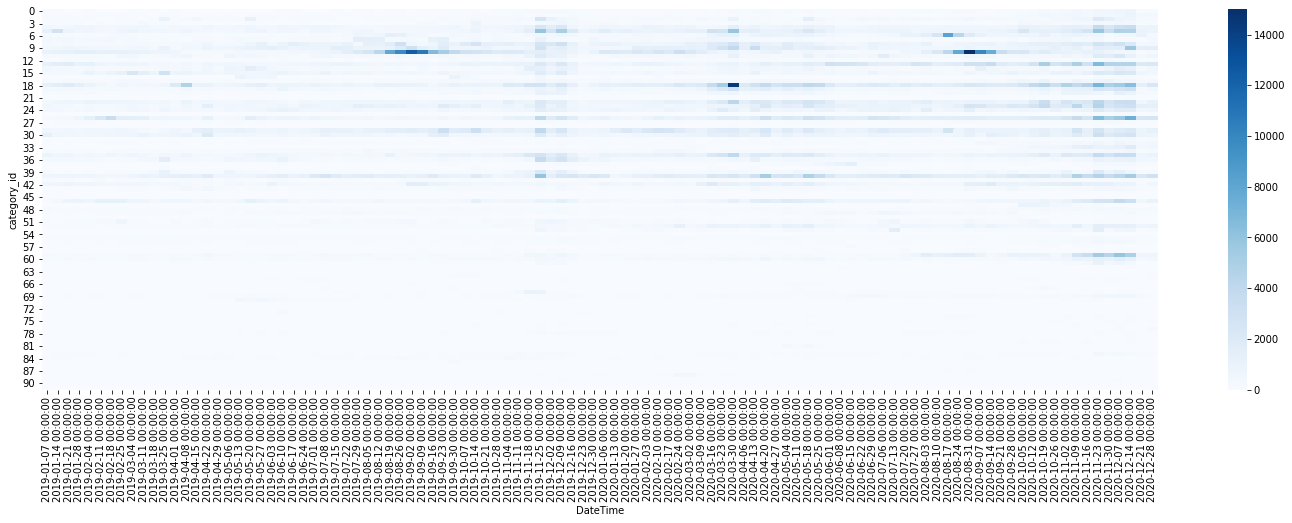

In [11]:
plt.figure(figsize = (25,7))
sns.heatmap(pivoted,  xticklabels=pivoted.columns, cmap = 'Blues')

In [22]:
# sales_df_combined.reset_index()[["category_id", "sales"]]\
# .groupby("category_id", as_index = True).boxplot(figsize=(20,5), subplots=False)

In [109]:
pivoted.T.corr()

category_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91
category_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.000000,0.810483,0.511160,0.608276,0.841054,0.666843,0.151910,-0.064667,0.575422,0.453827,-0.101152,0.607579,0.229862,0.778217,0.469655,0.526185,0.069967,0.727701,0.611528,0.761414,0.735120,0.492836,0.783206,0.752414,0.664414,0.859385,0.829197,0.600158,0.693389,0.361643,0.735998,0.648892,0.745789,0.839887,0.597755,0.770560,0.307741,0.227104,0.410321,0.537829,...,0.715854,0.563066,0.213265,0.613642,0.841467,0.352233,0.468305,0.882127,0.897145,0.787310,0.477598,0.671422,0.163431,0.359961,0.157978,0.150560,0.135855,0.750192,-0.092716,0.278787,0.447641,-0.140106,0.518027,0.444051,0.323470,0.293247,0.281848,0.438035,0.405785,0.171360,0.323559,0.679789,-0.201824,-0.112129,0.626373,0.134484,-0.049973,0.494987,0.109007,-0.125980
1,0.810483,1.000000,0.425565,0.577947,0.744996,0.543770,0.013355,-0.045204,0.434091,0.402126,-0.157723,0.476597,0.142174,0.757754,0.376675,0.513655,0.089351,0.753635,0.497493,0.608078,0.635356,0.506238,0.634051,0.713685,0.479430,0.744910,0.763520,0.422928,0.596180,0.260729,0.659161,0.591929,0.813135,0.911766,0.551579,0.609979,0.231539,0.140732,0.333409,0.445155,...,0.574460,0.476709,0.201515,0.498146,0.801347,0.279163,0.295600,0.774758,0.810453,0.659088,0.382268,0.539456,0.329326,0.312134,-0.018587,0.295374,0.007659,0.654069,-0.040435,0.199261,0.306171,-0.132053,0.369704,0.431732,0.190128,0.385624,0.142275,0.382240,0.502912,-0.006257,0.197822,0.583536,-0.222244,-0.195778,0.736579,0.027644,-0.072089,0.268838,0.090962,-0.090039
2,0.511160,0.425565,1.000000,0.421267,0.712147,0.729019,0.060257,0.090892,0.519497,0.344458,-0.095967,0.734994,0.487208,0.503070,0.509830,0.507930,0.255506,0.494024,0.501334,0.495052,0.616682,0.127930,0.594566,0.503311,0.597196,0.424606,0.631860,0.595773,0.615616,0.489545,0.578704,0.352679,0.473019,0.383483,0.290973,0.626189,0.636515,0.142805,0.456778,0.790636,...,0.480774,0.580521,0.136390,0.514504,0.554200,0.231782,0.385578,0.497932,0.545239,0.728528,0.112859,0.241298,0.053893,0.157573,0.124431,-0.033448,0.400453,0.481898,0.069284,0.256827,0.477557,-0.108184,0.301782,0.247787,0.369447,0.256140,0.392894,0.072365,0.117013,0.221408,0.180018,0.665612,0.038583,-0.041922,0.404804,0.046122,0.018302,0.216623,0.158449,0.006161
3,0.608276,0.577947,0.421267,1.000000,0.654104,0.582745,-0.043351,-0.047867,0.606065,0.240277,-0.082377,0.456962,0.476505,0.465147,0.363261,0.371325,0.138261,0.668526,0.342885,0.468913,0.646974,0.351124,0.474706,0.506220,0.395398,0.501269,0.513084,0.406204,0.494755,0.435605,0.434417,0.432134,0.525121,0.516640,0.406275,0.549593,0.441424,0.164893,0.387619,0.480909,...,0.375017,0.388332,0.068541,0.469264,0.643084,0.236929,0.408527,0.480187,0.599814,0.551436,0.190151,0.373666,0.339478,0.254686,-0.033147,0.176609,0.120796,0.454626,-0.101633,0.137075,0.418032,-0.046680,0.256742,0.279489,0.517599,0.236508,0.343450,0.195273,0.328419,0.111744,0.159826,0.618224,-0.091999,-0.085090,0.386757,-0.067135,0.045569,0.458473,0.152626,-0.098852
4,0.841054,0.744996,0.712147,0.654104,1.000000,0.838763,0.023069,-0.011552,0.641505,0.534148,-0.162633,0.786749,0.453578,0.681711,0.572673,0.638926,0.207569,0.688032,0.603899,0.746015,0.766712,0.425500,0.747171,0.657808,0.718191,0.796611,0.846779,0.603959,0.768509,0.478024,0.772661,0.627495,0.742810,0.726900,0.597423,0.803073,0.552845,0.206075,0.418611,0.748194,...,0.600726,0.682935,0.100184,0.668113,0.825204,0.198414,0.522563,0.800765,0.826276,0.898664,0.367638,0.612660,0.159634,0.339159,0.109088,0.019603,0.273298,0.681858,-0.003163,0.212869,0.558522,-0.109288,0.404515,0.396756,0.415481,0.339698,0.410239,0.390490,0.312608,0.155919,0.248742,0.837432,-0.077968,-0.086150,0.544511,-0.002735,0.027802,0.458901,0.108919,-

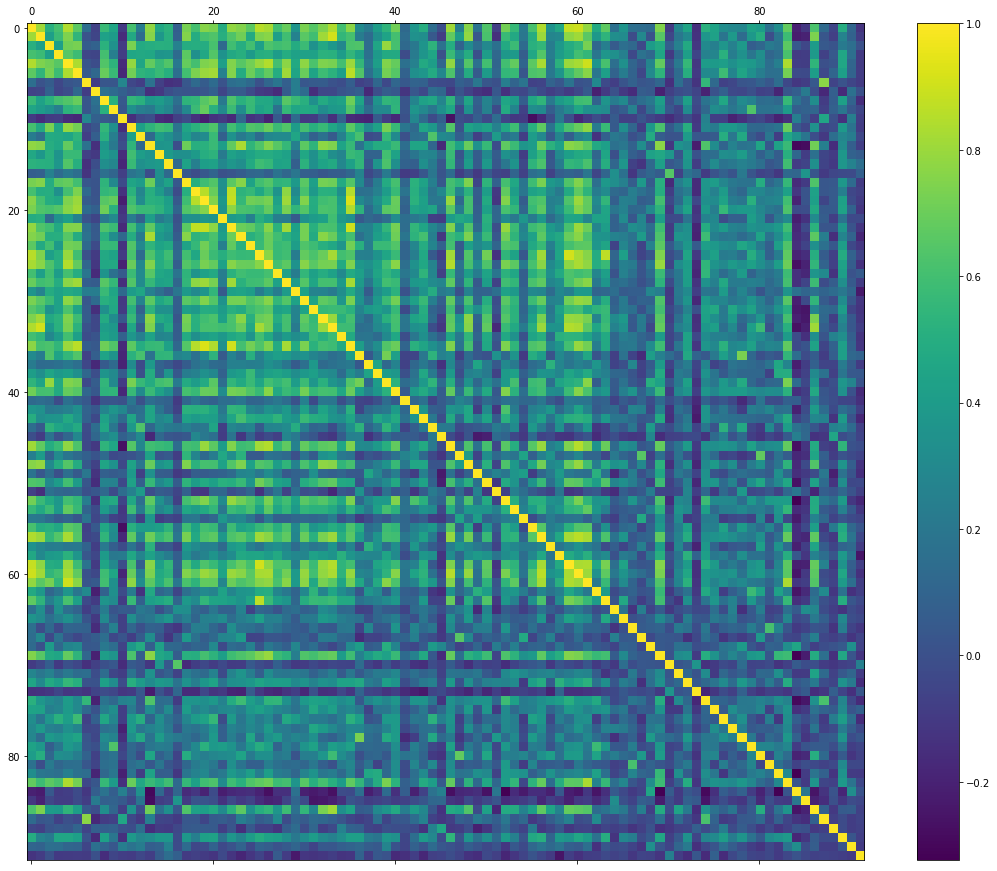

In [108]:
f = plt.figure(figsize=(19, 15))
plt.matshow(pivoted.T.corr(), fignum=f.number)
plt.colorbar()

In [111]:
sales_df_combined

sales  category_id  ...  traffic_lag_1W  sales_to_traffic
product_id DateTime                        ...                                  
1          2020-07-06      1           10  ...             NaN               NaN
           2020-07-20      1           10  ...             NaN               NaN
           2020-07-27      3           10  ...             NaN          3.000000
           2020-08-03      4           10  ...             1.0          2.000000
           2020-08-10      4           10  ...             2.0          1.333333
...                      ...          ...  ...             ...               ...
3135       2019-09-02      0           43  ...             NaN               NaN
           2019-10-21      0           43  ...             NaN               NaN
           2019-08-12      0           43  ...             NaN               NaN
           2019-06-17      0           43  ...             NaN               NaN
           2019-04-15      0           43  ...             NaN               NaN

[304304 rows x 9 columns]

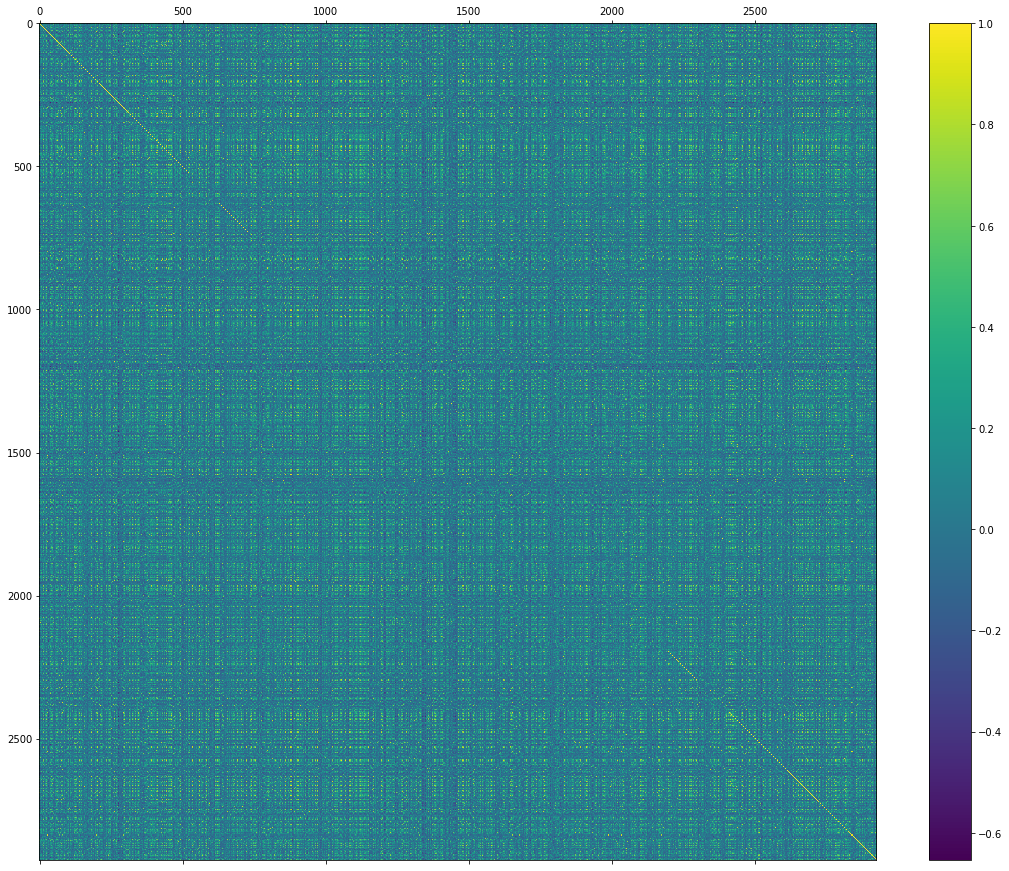

In [114]:
f = plt.figure(figsize=(19, 15))
plt.matshow(sales_df_combined.reset_index()[["product_id", "DateTime", "sales"]].pivot(index = "product_id", columns = "DateTime", values = "sales").fillna(0).T.corr(), fignum=f.number)
plt.colorbar()

###### policzyc korelacje i cross korelacje dla szeregow

In [22]:
from scipy import signal
corr = signal.correlate(pivoted.iloc[0,:].values, pivoted.iloc[1,:].values)
corr /= np.max(corr)

#### What is the length of time series within min max horizons per product_id

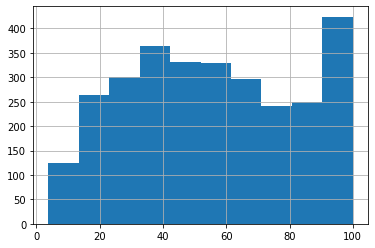

In [12]:
# how many obsevations do we have per each product_id
original_count = sales_df_copy.set_index(["product_id", "DateTime"])[["sales"]].groupby(level=0).count().rename(columns={'sales':'weeks_original'})

# how much do we have when we expand the gaps in between
expanded_count = sales_df_combined[["sales"]].groupby(level=0).count().rename(columns={'sales':'weeks_expanded'})

result = pd.concat([expanded_count, original_count], axis=1, join="outer").pipe(lambda x: x.assign(nonzero_obs_share = 100*round(x.weeks_original/x.weeks_expanded,4)))

result.nonzero_obs_share.hist()

In [13]:
result.sort_values(by = ["nonzero_obs_share"])

,weeks_expanded,weeks_original,nonzero_obs_share
product_id,,,
2537,53,2,3.77
866,76,3,3.95
1636,74,3,4.05
1303,74,3,4.05
1346,89,4,4.49
...,...,...,...
2658,46,46,100.00
1308,35,35,100.00
2894,1,1,100.00


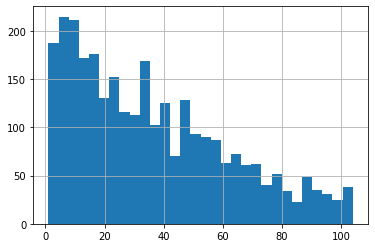

In [14]:
result.weeks_original.hist(bins = 30)

In [15]:
def time_interval_between_obs(ts):
  series_with_time = ts.index.get_level_values(1).to_series().diff().astype('timedelta64[W]').values
  all_obs = len(series_with_time)-1
  counts = np.array(np.unique(series_with_time,  return_counts = True))
  argmax_counts_freq = np.argmax(counts[1])
  max_freq_value = counts[0][argmax_counts_freq]
  return (ts.index.get_level_values(0)[0], all_obs, max_freq_value, round(counts[1][argmax_counts_freq]/all_obs,4))

In [16]:
weeks_frequency = pd.DataFrame(list(sales_df_copy.set_index(["product_id", "DateTime"]).sort_index(ascending = True).groupby(level=0).apply(lambda x: time_interval_between_obs(x)))
, columns =['product_id', 'all_obs' ,'freq_in_weeks_dominating', 'perc'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


In [17]:
weeks_frequency

,product_id,all_obs,freq_in_weeks_dominating,perc
0,1,20,1.0,0.8500
1,2,49,1.0,0.9796
2,3,26,1.0,0.6923
3,4,41,1.0,0.9512
4,5,45,1.0,0.7333
...,...,...,...,...
2921,3131,9,1.0,0.3333
2922,3132,20,1.0,0.9000
2923,3133,15,1.0,0.9333
2924,3134,8,1.0,0.3750


##Benchmark baseline models

In [72]:
sample = sales_df_combined.loc[[2658, 1308]]

NameError: ignored

In [24]:
sample

sales  category_id  ...  traffic_lag_1W  sales_to_traffic
product_id DateTime                        ...                                  
2658       2020-07-06     61           22  ...             NaN          3.050000
           2020-07-20     74           22  ...            20.0          2.551724
           2020-07-27     50           22  ...            29.0          2.272727
           2020-08-03     96           22  ...            22.0          2.285714
           2020-08-10     60           22  ...            42.0          8.571429
...                      ...          ...  ...             ...               ...
1308       2019-09-02      0           23  ...             NaN               NaN
           2019-10-21      0           23  ...             NaN               NaN
           2019-08-12      0           23  ...             NaN               NaN
           2019-06-17      0           23  ...             NaN               NaN
           2019-04-15      0           23  ...             NaN               NaN

[208 rows x 9 columns]

In [25]:
unique_index = sample.sales.index.get_level_values('product_id').unique()

In [ ]:
for prod_id in unique_index:
    print(prod_id)
    forecast = NaiveForecast(sample.sales.loc[prod_id][:-3], horizon = 3)
    print(forecast)
    print(wmape(sample.sales.loc[prod_id][-3:], forecast))

In [ ]:
# linear regression

In [18]:
# extended only to global max date horizon
sales_df_combined_without_lag = prepare_sales_data(sales_data, categories, traffic, True, True, [1,2,3])

In [19]:
sales_df_combined_without_lag.loc[[2658, 1308]]

sales  category_id  ...  sales_lag_3W  traffic_lag_3W
product_id DateTime                        ...                              
2658       2020-02-17   17.0           22  ...           0.0             0.0
           2020-02-24   37.0           22  ...           0.0             0.0
           2020-03-02   25.0           22  ...           0.0             0.0
           2020-03-09  170.0           22  ...          17.0             NaN
           2020-03-16  242.0           22  ...          37.0            14.0
...                      ...          ...  ...           ...             ...
1308       2020-11-30    8.0           23  ...          11.0            15.0
           2020-12-07   25.0           23  ...          10.0            11.0
           2020-12-14   17.0           23  ...          17.0            11.0
           2020-12-21    8.0           23  ...           8.0             9.0
           2020-12-28   13.0           23  ...          25.0            13.0

[81 rows x 12 columns]

In [20]:
sample = sales_df_combined_without_lag.loc[[2658, 1308]]

In [24]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10, test_size = 3)

     |████████████████████████████████| 22.3 MB 1.6 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [32]:
sample.groupby(level = 0).apply(lambda x: x.reset_index(level = 0))

sales  category_id  ...  sales_lag_3W  traffic_lag_3W
product_id DateTime                        ...                              
2658       2020-02-17   17.0           22  ...           0.0             0.0
           2020-02-24   37.0           22  ...           0.0             0.0
           2020-03-02   25.0           22  ...           0.0             0.0
           2020-03-09  170.0           22  ...          17.0             NaN
           2020-03-16  242.0           22  ...          37.0            14.0
...                      ...          ...  ...           ...             ...
1308       2020-11-30    8.0           23  ...          11.0            15.0
           2020-12-07   25.0           23  ...          10.0            11.0
           2020-12-14   17.0           23  ...          17.0            11.0
           2020-12-21    8.0           23  ...           8.0             9.0
           2020-12-28   13.0           23  ...          25.0            13.0

[81 rows x 12 columns]

In [73]:
score = []
for tr_index, val_index in tscv.split(sample.loc[2658]):
  print (tr_index, val_index)
  X_tr, X_val = sample.loc[2658][["sales"]].iloc[tr_index], sample.loc[2658][["sales"]].iloc[val_index]
  print(X_tr)
  print(X_val)
  forecast = NaiveForecast(X_tr.sales, horizon = 3)
  print(forecast)
  print(wmape(X_val.sales, forecast))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [16 17 18]
            sales
DateTime         
2020-02-17   17.0
2020-02-24   37.0
2020-03-02   25.0
2020-03-09  170.0
2020-03-16  242.0
2020-03-23  316.0
2020-03-30  757.0
2020-04-06  292.0
2020-04-13  268.0
2020-04-20  372.0
2020-04-27  216.0
2020-05-04  250.0
2020-05-11  156.0
2020-05-18  132.0
2020-05-25  118.0
2020-06-01   65.0
            sales
DateTime         
2020-06-08   33.0
2020-06-15   50.0
2020-06-22   45.0
2020-06-08    65.0
2020-06-15    65.0
2020-06-22    65.0
Freq: W-MON, dtype: float64
(52.343799999999995, DateTime
2020-06-08   -32.0
2020-06-15   -15.0
2020-06-22   -20.0
dtype: float64)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] [19 20 21]
            sales
DateTime         
2020-02-17   17.0
2020-02-24   37.0
2020-03-02   25.0
2020-03-09  170.0
2020-03-16  242.0
2020-03-23  316.0
2020-03-30  757.0
2020-04-06  292.0
2020-04-13  268.0
2020-04-20  372.0
2020-04-27  216.0
2020-05-04  250.0
2020-05-11  156

In [12]:
score = []
for tr_index, val_index in tscv.split(sample.loc[2658]):
  print (tr_index, val_index)
  X_tr, X_val = sample.loc[2658][["sales"]].iloc[tr_index], sample.loc[2658][["sales"]].iloc[val_index]
  print(X_tr)
  print(X_val)
  forecast = NaiveForecast(X_tr.sales, horizon = 3)
  print(forecast)
  print(mean_absolute_percentage_error(X_val.sales, forecast))

NameError: ignored

In [ ]:
# Spot Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
 tscv = TimeSeriesSplit(n_splits=10)
    
 cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='mape')

In [40]:
NaiveForecast(X_tr, horizon = 3)

2020-12-14    262.0
2020-12-21    262.0
2020-12-28    262.0
Freq: W-MON, dtype: float64

In [38]:
X_tr, X_val 

(            sales
 DateTime         
 2020-02-17   17.0
 2020-02-24   37.0
 2020-03-02   25.0
 2020-03-09  170.0
 2020-03-16  242.0
 2020-03-23  316.0
 2020-03-30  757.0
 2020-04-06  292.0
 2020-04-13  268.0
 2020-04-20  372.0
 2020-04-27  216.0
 2020-05-04  250.0
 2020-05-11  156.0
 2020-05-18  132.0
 2020-05-25  118.0
 2020-06-01   65.0
 2020-06-08   33.0
 2020-06-15   50.0
 2020-06-22   45.0
 2020-06-29   34.0
 2020-07-06   61.0
 2020-07-13   66.0
 2020-07-20   74.0
 2020-07-27   50.0
 2020-08-03   96.0
 2020-08-10   60.0
 2020-08-17   57.0
 2020-08-24   25.0
 2020-08-31    9.0
 2020-09-07   36.0
 2020-09-14   43.0
 2020-09-21   69.0
 2020-09-28  102.0
 2020-10-05   72.0
 2020-10-12  216.0
 2020-10-19  266.0
 2020-10-26   26.0
 2020-11-02  100.0
 2020-11-09  166.0
 2020-11-16  152.0
 2020-11-23  264.0
 2020-11-30  227.0
 2020-12-07  262.0,             sales
 DateTime         
 2020-12-14  214.0
 2020-12-21   39.0
 2020-12-28    8.0)

DateTime
2020-12-14    214.0
2020-12-21     39.0
2020-12-28      8.0
Name: sales, dtype: float64

In [43]:
NaiveForecast(X_tr, horizon = 3)

2020-12-14    262.0
2020-12-21    262.0
2020-12-28    262.0
Freq: W-MON, dtype: float64

In [58]:
mean_absolute_percentage_error(X_val.sales, NaiveForecast(X_tr, horizon = 3))

12.564082594456428

In [46]:
np.mean(np.abs((X_val.sales - NaiveForecast(X_tr, horizon = 3))/X_val.sales))

12.564082594456428

In [ ]:
sklearn.model_selection.cross_validate

In [1]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5, test_size = 3)

TypeError: ignored

In [ ]:
%%time

cv_scores = cross_val_score(logit, X_train, y_train, cv=tscv, 
                            scoring='rmse', n_jobs=1)

In [ ]:
score = []
for tr_index, val_index in tscv.split(sample.loc[2658]):
  print (tr_index, val_index)
  X_tr, X_val = sample.loc[2658][["sales"]].iloc[tr_index], sample.loc[2658][["sales"]].iloc[val_index]
  print(X_tr)
  print(X_val)
  forecast = NaiveForecast(X_tr.sales, horizon = 3)
  print(forecast)
  print(wmape(X_val.sales, forecast))